In [1]:
import numpy as np
import scipy as sp
from iminuit import Minuit, cost

x = np.random.normal(2 ,4, size=2000)

# MoM

# function to compute mean from moments
def mu(m1, m2):
    return m1

# function to compute sigma from moments
def sg(m1, m2):
    return np.sqrt( m2 - m1**2 )

# compute 1st and 2nd central moments from sample
m1_hat = sp.stats.moment(x, moment=1, center=0)
m2_hat = sp.stats.moment(x, moment=2, center=0)

# propagate to estimates of mu and sg
mu_hat = mu(m1_hat, m2_hat)
sg_hat = sg(m1_hat, m2_hat)

# and do a minuit fit
def model(x, mu, sg):
    return sp.stats.norm.pdf(x, mu, sg)

nll = cost.UnbinnedNLL(x, model )
mi  = Minuit(nll, mu=1, sg=3)
mi.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.122e+04                  │              Nfcn = 46               │
│ EDM = 1.33e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   2.01    │   0.09    │            │            │         │         │       │
│ 1 │ sg   │   4.00    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────┐
│    │    mu    sg │
├────┼─────────────┤
│ mu │ 0.008 0.000 │
│ sg │ 0.000 0.004 │
└────┴─────────────┘

In [2]:
print('MLE:', *mi.values )
print('MOM:', mu_hat, sg_hat)

print(mi.covariance)

MLE: 2.0075076189603407 4.000944002581343
MOM: 2.0076043531226495 4.000918867955887
┌────┬─────────────┐
│    │    mu    sg │
├────┼─────────────┤
│ mu │ 0.008 0.000 │
│ sg │ 0.000 0.004 │
└────┴─────────────┘


In [3]:
## covariance of moment estimates
N = len(x)

x1_bar = np.mean(x)
x2_bar = np.mean(x**2)

cov_x11 = 1/(N*(N-1)) * np.sum( (x-x1_bar) * ( x - x1_bar) )
cov_x12 = 1/(N*(N-1)) * np.sum( (x-x1_bar) * ( x**2 - x2_bar) )
cov_x22 = 1/(N*(N-1)) * np.sum( (x**2-x2_bar) * ( x**2 - x2_bar) )

cov_mus_hat = np.array( [ [cov_x11, cov_x12], [ cov_x12, cov_x22] ] )


In [7]:
# propagate to parameter estimates

from jacobi import propagate

# jacobi needs a single wrapped function
theta = lambda p: np.array([ mu(*p), sg(*p) ])

mom, mom_cov = propagate( theta, [m1_hat, m2_hat], cov_mus_hat)

In [8]:
print('MLE:', *mi.values)
print('MoM:', *mom)

print('MLE_err:', *mi.errors)
print('MoM_err:', *np.sqrt(np.diag(mom_cov)))

print('MLE_cov:')
print(mi.covariance)

print('MoM_cov:')
print(mom_cov)

MLE: 2.0075076189603407 4.000944002581343
MoM: 2.0076043531226495 4.000918867955887
MLE_err: 0.08946385508881148 0.06326104695212728
MoM_err: 0.08948563981918879 0.06285523879073877
MLE_cov:
┌────┬─────────────┐
│    │    mu    sg │
├────┼─────────────┤
│ mu │ 0.008 0.000 │
│ sg │ 0.000 0.004 │
└────┴─────────────┘
MoM_cov:
[[ 0.00800768 -0.00013523]
 [-0.00013523  0.00395078]]


In [6]:
# Another Method of moments example

# accept-reject
xrange = (-3, 3)
true_alpha = 1.3
true_beta = 2.4

# norm terms for pdf
d1 = xrange[1] - xrange[0]
d2 = (xrange[1]**2 -xrange[0]**2)/2 
d3 = (xrange[1]**3 -xrange[0]**3)/3 

def pdf(x, alpha, beta):
    
    return (1 + alpha*x + beta*x**2) / (d1 + alpha*d2 + beta*d3)

# find max pdf
from scipy.optimize import minimize
truef = lambda x: -pdf(x, true_alpha, true_beta)
x = minimize(truef, x0=[0], bounds=[xrange])
maxy = -truef(x.x[0])

def gen(size=1):
    evs = []
    while len(evs)<size:
        # gen [-pi,pi]
        x = np.random.uniform(*xrange)
        # gen [0,maxy]
        y = np.random.uniform(0,maxy)
        # eval pdf
        p = pdf(x, true_alpha, true_beta)
        # accept-reject
        if y<p:
            evs.append(x)
    if size==1:
        return evs[0]
    else:
        return np.array(evs)


In [7]:
# gen sample
x_i = gen(size=10000)

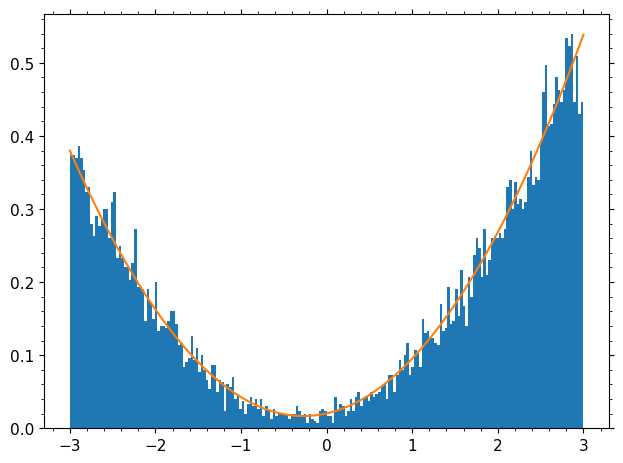

In [8]:
# check it looks ok
import matplotlib.pyplot as plt
plt.hist(x_i, density=True, bins=200)
x = np.linspace(*xrange,100)
plt.plot(x, pdf(x, true_alpha, true_beta))